In [1]:
import numpy as np
from numpy import ones
from numpy_sugar import ddot
import os
import sys
import pandas as pd
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
from limix.qc import quantile_gaussianize

In [2]:
perm = None
chrom = 6

In [3]:
## input files folder
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/input_files/DA_all_conditions/"

In [4]:
## this file will map pseudocells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0714i-iudw_1,HPSI0714i-iudw_1--DA--d30--0
1,HPSI0714i-iudw_1,HPSI0714i-iudw_1--DA--d30--1
2,HPSI0714i-iudw_1,HPSI0714i-iudw_1--DA--d30--2
3,HPSI0714i-iudw_1,HPSI0714i-iudw_1--DA--d30--3
4,HPSI0714i-iudw_1,HPSI0714i-iudw_1--DA--d30--4


In [5]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 192


In [6]:
## read in genotype file
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:07<00:00, 122.41s/it]


In [7]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 174


In [8]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [9]:
## and decompose such as K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)
del K

In [10]:
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 9982
Sample mapping number of rows AFTER intersection: 9085


In [11]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [12]:
# environments
# meta-cells by PCs (10)
E_file = input_files_dir+"10PCs.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [13]:
# subselect to only SNPs on right chromosome
G_sel = G.where(G.chrom == str(chrom), drop=True)
G_sel

<xarray.DataArray 'genotype' (sample: 1610, variant: 735214)>
dask.array<where, shape=(1610, 735214), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
  * variant  (variant) object '6_6_202452_C_T' ... '6_6_170982403_T_G'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '6' '6' '6' '6' '6' '6' ... '6' '6' '6' '6' '6'
    snp      (variant) object '6_202452_C_T' ... '6_170982403_T_G'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 202452 202777 202901 ... 170978753 170982403
    a0       (variant) object 'C' 'C' 'C' 'T' 'G' 'C' ... 'G' 'G' 'A' 'C' 'T'
    a1       (variant) object 'T' 'T' 'T' 'G' 'C' 'T' ... 'A' 'A' 'G' 'T' 'G'

In [14]:
# and to individuals in smf
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 38 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [15]:
n_factors = 10
# E = E.values[:,0:n_factors]

In [16]:
# get eigendecomposition of EEt
[U, S, _] = economic_svd(E)
us = U * S
# get decomposition of K*EEt
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]

In [17]:
# Phenotype (meta-cell gene expression)
phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/input_files/DA_all_conditions/phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)

In [18]:
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (32738, 9982)
Phenotype shape AFTER selection: (32738, 9085)


In [19]:
# Filter on specific gene-SNP pairs
# eQTL from neuroseq DA (day30 + day52 + day52 ROT treated)
neuro_eqtl_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/input_files/DA_all_conditions/DA_eqtl_allconditions_FDR5pct.csv" # consider filter further (significant only)
neuro_eqtl = pd.read_csv(neuro_eqtl_file)
neuro_eqtl["chrom"] = [int(i[:i.find("_")]) for i in neuro_eqtl["snp_id"]]
genes = neuro_eqtl[neuro_eqtl['chrom']==int(chrom)]['feature'].unique()

In [20]:
len(genes)

61

In [21]:
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [22]:
E = quantile_gaussianize(E)

In [38]:
i=14
trait_name = genes[i]
trait_name

'B3GAT2'

In [39]:
y = phenotype.sel(trait=trait_name)

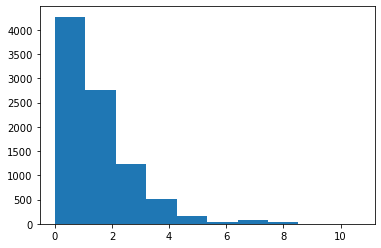

In [40]:
import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

In [41]:
y = np.asarray(y)
(y == 0).astype(int).sum()/len(y)>0.3

False

In [42]:
y = quantile_gaussianize(y)

In [43]:
# null model
slmm2 = StructLMM2(y, M, E, Ls)

In [44]:
leads = neuro_eqtl[neuro_eqtl['feature']==trait_name]['snp_id'].unique()
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]

In [45]:
pvals = slmm2.scan_interaction(G_tmp, perm)[0]
pv = pd.DataFrame({"chrom":G_tmp.chrom.values, 
    "pv":pvals,
    "variant":G_tmp.snp.values})
pv.head()

100%|██████████| 1/1 [00:59<00:00, 59.82s/it]


,chrom,pv,variant
0,6,0.000013,6_71415029_T_A


In [46]:
folder = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/April2021/PCA/"
outfilename = f"{folder}PC10/{trait_name}.tsv"
outfilename

'/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/April2021/PCA/PC10/B3GAT2.tsv'

In [47]:
pv.to_csv(outfilename, sep='\t')